# Handwritten Postal Codes

__Convolutional Neural Networks__

_By Marnick van der Arend & Jeroen Smienk_

![Sample Digits](digits_sample.png)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib inline

__MODEL_PATH = 'conv_models'
__DATA_PATH = 'dataset-images'
__TENSOR_LOG_DIR = 'logs'

## Dataset

480 Images consisting of 4 digit postal codes with the label as the file name e.g. `3365.png`.

In [37]:
def crop(image):
    """
    Crop an 128x32 image to 4 32x32 images
    
    Parameters
    ----------
    path : string
    Path to images
    """
    digits = []
    x,y,w,h = 0,0,32,32
    for i in range(4):
        x = i*w
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        digits.append(gray[y:y+h, x:x+w])
    return digits

def get_images_in_path(path, extension):
    """
    Create a list of all images and their file names (labels) in a certain path
    
    Parameters
    ----------
    path : string
    Path to images
    """
    img_list = []
    for name in os.listdir(path):
        if name.endswith(extension):
            img = cv2.imread(os.path.join(path, name))
            label = name[:-len(extension)] # remove extension
            images = crop(img)
            for i in range(4):
                img_list.append((images[i], int(label[i])))
    return img_list

### Creating the dataset

We split the 480 images in 1920 individual black-and-white digits and save them with their correct label as a tuple in a list.

In [38]:
images = get_images_in_path(__DATA_PATH, '.png')

Let's see what kind of digits are in the set by plotting them with their labels:

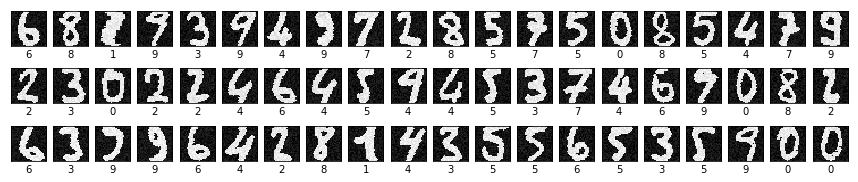

In [40]:
PLOT_SIZE = 60
ROW_WIDTH = 20
plt.figure(figsize=(15, PLOT_SIZE / ROW_WIDTH))
for i in range(PLOT_SIZE):
    plt.subplot(PLOT_SIZE / ROW_WIDTH, ROW_WIDTH, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(images[i][1])
    plt.imshow(images[i][0], cmap=plt.cm.binary)

##### One hot encode the label

In [4]:
one_hot_df_labels = pd.get_dummies(df["label"], prefix='label')
one_hot_df_labels.head(10)

# Merge data with one hot encoded labels
data = pd.concat([df, one_hot_df_labels], axis=1)
data = data.drop(['label'], axis=1)
data.head(5)

,data,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9
0,"[[232, 232, 232], [240, 240, 240], [238, 238, ...",0,0,0,0,0,0,1,0,0,0
1,"[[242, 242, 242], [240, 240, 240], [232, 232, ...",0,0,0,0,0,0,0,0,1,0
2,"[[242, 242, 242], [231, 231, 231], [242, 242, ...",0,1,0,0,0,0,0,0,0,0
3,"[[232, 232, 232], [242, 242, 242], [238, 238, ...",0,0,0,0,0,0,0,0,0,1
4,"[[249, 249, 249], [243, 243, 243], [246, 246, ...",0,0,0,1,0,0,0,0,0,0


In [5]:
# Shapes of training set
print(data.data[:].shape)
print("Training set (images) shape: {shape}".format(shape=data.iloc[:,:1].shape))
print("Training set (labels) shape: {shape}".format(shape=data.iloc[:,1:].shape))

(1920,)
Training set (images) shape: (1920, 1)
Training set (labels) shape: (1920, 10)


In order to classify these categorical labels, we have to 'one-hot encode' them:

In [6]:
# Reshape training and testing image
train_X = data.train.images.reshape(-1, 28, 28, 1)
test_X = data.test.images.reshape(-1,28,28,1)

# Create variable for Y
train_Y = data.train.labels
test_Y = data.test.labels

train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

AttributeError: 'DataFrame' object has no attribute 'train'

We split on the training data to create the validation set.

In [ ]:
split = int(train_X.shape[0] * .90)
valid_X = train_X[split:]
train_X = train_X[:split]
valid_Y = train_Y[split:]
train_Y = train_Y[:split]

print('Split X (train, test, validation):', train_X.shape, test_X.shape, valid_X.shape)
print('Split Y (train, test, validation):', train_Y.shape, test_Y.shape, valid_Y.shape)

In [ ]:
def get_batch(data, labels, batch_size):
    x_batch = data.sample(frac=batch_size / len(data.index))
    return x_batch, labels.loc[x_batch.index]

## Models

We designed several models:

rank | name | layers | score
--- | --- | --- | ---
5 | model_8 | (64, Tanh, Drop=.2) (128, Tanh, Drop=.3) (256, Tanh, Drop=.4) (512, Tanh, Drop=.5) (64, Tanh) | 0.93714285
4 | model_7 | (64, ReLU) (128, ReLU) (256, ReLU) (512, ReLU, Drop=.3) (64, ReLU) | 0.94057140
3 | model_6 | (200, Tanh) (300, Tanh) (600, Tanh) | 0.97828573
1 | model_5_2 | (600, Tanh, Drop=.3) (300, Tanh, Drop=.3) (200, Tanh, Drop=.3) | 0.98742855
2 | model_5 | (600, Tanh) (300, Tanh) (200, Tanh) | 0.97942860
6 | model_4 | (128, Tanh) (64, Tanh) (32, Tanh) | 0.87771430
7 | model_3 | (12, ReLU) (24, ReLU) (48, ReLU, Drop=.1) (96, ReLU) | 0.73028570
8 | model_2 | (128, ReLU) (64, ReLU) (32, ReLU) | 0.82400000
9 | model_1 | (128, Sigmoid) | 0.66628570

Dropout has a positive effect on the score as can be seen in the table. We also found that the tanh activation function performed well. 

- Model 1: BLUE
- Model 2: RED
- Model 3: LIGHT BLUE
- Model 4: PINK
- Model 5: GREEN
- Model 6: GRAY
- Model 7: ORANGE
- Model 8: ORANGE

### Batch Accuracy

![Batch Accuracy](acc.png)

### Batch Loss

![Batch Loss](loss.png)

In [ ]:
def model_1(x, output_shape):
    """
    """
    l_1 = tf.layers.conv2d(x, filters=32, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu, name="l_1")
    
    return tf.layers.dense(l_1, units=output_shape, activation=None)

In [ ]:
def model_2(x, output_shape):
    """
    Three hidden layers with different amounts of neurons and relu activation functions.
    """
    l_1 = tf.layers.dense(x, units=128, activation=tf.nn.relu)
    l_2 = tf.layers.dense(l_1, units=64, activation=tf.nn.relu)
    l_3 = tf.layers.dense(l_2, units=32, activation=tf.nn.relu)
    return tf.layers.dense(l_3, units=output_shape, activation=None)

In [ ]:
def model_3(x, output_shape):
    """
    Six hidden layers with different amounts of neurons and 
    relu activation functions and 2 dropout layers.
    """
    l_1 = tf.layers.dense(x, units=12, activation=tf.nn.relu)
    l_2 = tf.layers.dense(l_1, units=24, activation=tf.nn.relu)
    l_3 = tf.layers.dense(l_2, units=48, activation=tf.nn.relu)
    d_3 = tf.layers.dropout(l_3, rate=.1)
    l_4 = tf.layers.dense(d_3, units=96, activation=tf.nn.relu)
    return tf.layers.dense(l_4, units=output_shape, activation=None)

In [ ]:
def model_4(x, output_shape):
    """
    Three hidden layers with different amounts of neurons and relu activation functions.
    """
    l_1 = tf.layers.dense(x, units=128, activation=tf.nn.tanh)
    l_2 = tf.layers.dense(l_1, units=64, activation=tf.nn.tanh)
    l_3 = tf.layers.dense(l_2, units=32, activation=tf.nn.tanh)
    return tf.layers.dense(l_3, units=output_shape, activation=None)

In [ ]:
def model_5(x, output_shape):
    """
    High number of neurons in layers, decreasing per layer
    """
    l_1 = tf.layers.dense(x, units=600, activation=tf.nn.tanh)
    l_2 = tf.layers.dense(l_1, units=300, activation=tf.nn.tanh)
    l_3 = tf.layers.dense(l_2, units=200, activation=tf.nn.tanh)
    return tf.layers.dense(l_3, units=output_shape, activation=None)

In [ ]:
def model_5_2(x, output_shape):
    """
    High number of neurons in layers, decreasing per layer
    """
    l_1 = tf.layers.dense(x, units=600, activation=tf.nn.tanh)
    d_1 = tf.layers.dropout(l_1, rate=.3)
    l_2 = tf.layers.dense(d_1, units=300, activation=tf.nn.tanh)
    d_2 = tf.layers.dropout(l_2, rate=.3)
    l_3 = tf.layers.dense(d_2, units=200, activation=tf.nn.tanh)
    d_3 = tf.layers.dropout(l_3, rate=.3)
    return tf.layers.dense(d_3, units=output_shape, activation=None)

In [ ]:
def model_6(x, output_shape):
    """
    High number of neurons in layers, increasing per layer
    """
    l_1 = tf.layers.dense(x, units=200, activation=tf.nn.tanh)
    l_2 = tf.layers.dense(l_1, units=300, activation=tf.nn.tanh)
    l_3 = tf.layers.dense(l_2, units=600, activation=tf.nn.tanh)
    return tf.layers.dense(l_3, units=output_shape, activation=None)

In [ ]:
def model_7(x, output_shape):
    """
    """
    l_1 = tf.layers.dense(x, units=64, activation=tf.nn.relu)
    l_2 = tf.layers.dense(l_1, units=128, activation=tf.nn.relu)
    l_3 = tf.layers.dense(l_2, units=256, activation=tf.nn.relu)
    l_4 = tf.layers.dense(l_3, units=512, activation=tf.nn.relu)
    d_4 = tf.layers.dropout(l_4, rate=.3)
    l_5 = tf.layers.dense(d_4, units=64, activation=tf.nn.relu)
    return tf.layers.dense(l_5, units=output_shape, activation=None)

In [ ]:
def model_8(x, output_shape):
    """
    """
    l_1 = tf.layers.dense(x, units=64, activation=tf.nn.tanh)
    d_1 = tf.layers.dropout(l_1, rate=.2)
    l_2 = tf.layers.dense(d_1, units=128, activation=tf.nn.tanh)
    d_2 = tf.layers.dropout(l_2, rate=.3)
    l_3 = tf.layers.dense(d_2, units=256, activation=tf.nn.tanh)
    d_3 = tf.layers.dropout(l_3, rate=.4)
    l_4 = tf.layers.dense(d_3, units=512, activation=tf.nn.tanh)
    d_4 = tf.layers.dropout(l_4, rate=.5)
    l_5 = tf.layers.dense(d_4, units=64, activation=tf.nn.tanh)
    return tf.layers.dense(l_5, units=output_shape, activation=None)

We start with the placeholder for our 5-dice input and 7-class output and choose a model:

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 1, train_X.shape[1], train_X.shape[2]], name='x')
y = tf.placeholder(tf.float32, shape=[None, train_Y.shape[1]], name='y')

model_fn = model_1
y_pred = model_fn(x, train_Y.shape[1])

## Training

We choose an optimizer, a loss functon and metrics:

In [ ]:
# Loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_pred)
loss_fn = tf.reduce_mean(cross_entropy)

# Optimizer minimizes the loss
optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss_fn)

# Accuracy metric
#   checks if the indices of the highest values in the real 
#   and predicted arrays are equal
prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pred, axis=1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

We train the model using a certain batch size and for a number of iterations while posting scalars to TensorBoard:

In [ ]:
iters = 3000
train_batch_size = 200
test_batch_size = 50

session = tf.Session()
with session:
    session.run(tf.global_variables_initializer())

    sum_loss_train = tf.summary.scalar('loss_train', loss_fn)
    sum_loss_test = tf.summary.scalar('loss_test', loss_fn)
    sum_acc_train = tf.summary.scalar('acc_train', accuracy)
    sum_acc_test = tf.summary.scalar('acc_test', accuracy)
    tf.summary.merge_all()
    writer = tf.summary.FileWriter(os.path.join(__TENSOR_LOG_DIR, model_fn.__name__), session.graph)
    
    for i in range(iters):
        x_batch, y_batch = get_batch(train_X, train_Y, train_batch_size)
        loss_val, _, acc_val, sum_1, sum_2 = session.run([loss_fn, optimizer, accuracy, 
                                                          sum_loss_train, sum_acc_train], 
                                                         feed_dict={x: x_batch, y: y_batch})

        writer.add_summary(sum_1, global_step=i)
        writer.add_summary(sum_2, global_step=i)
    #     print('Training - i:', i+1, 'Loss:', loss_val, 'Accuracy:', acc_val)

        # Validate every 50 iterations
        if i % 50 == 0:
            acc_val, sum_1, sum_2 = session.run([accuracy, sum_loss_test, sum_acc_test], 
                                                feed_dict={x: X_test, y: Y_test})

            writer.add_summary(sum_1, global_step=i)
            writer.add_summary(sum_2, global_step=i)
            print('Validation - i:', i+1, ' Accuracy:', acc_val)
    

    # Validate the model with unseen data
    acc_val = session.run([accuracy], feed_dict={x: valid_X, y: valid_Y})

    # Print test metrics
    print('Accuracy:', acc_val)

## Validation

We validate the model with the data it has not seen yet:

In [ ]:
# with session:
#     # Validate the model with unseen data
#     acc_val = session.run([accuracy], feed_dict={x: X_valid, y: Y_valid})

#     # Print test metrics
#     print('Accuracy:', acc_val)

## Exporting & Importing

In [ ]:
save_path = '{}.ckpt'.format(os.path.join(__MODEL_PATH, model_fn.__name__, model_fn.__name__))

model_to_load = model_5_2

load_path = '{}.ckpt'.format(os.path.join(__MODEL_PATH, model_to_load.__name__, model_to_load.__name__))

We save the model that worked best:

In [ ]:
# with session:
#     tf.train.Saver().save(session, save_path)

We load the model that worked best:

In [ ]:
with tf.Session() as saved_session:
    tf.train.Saver().restore(saved_session, load_path)

    # Validate the model with unseen data
    acc_val = saved_session.run([accuracy], feed_dict={x: X_valid, y: Y_valid})

    # Print test metrics
    print('Accuracy:', acc_val)

## Conclusion